In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import ConcatDataset, DataLoader, Sampler, Dataset
from src.data_loader import *
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

In [2]:
plt.rcParams.update({'font.family': 'cmr10',
                     'font.size': 12,
                     'axes.unicode_minus': False,
                     'axes.labelsize': 12,
                     'axes.labelsize': 12,
                     'figure.figsize': (4, 4),
                     'figure.dpi': 160,
                     'mathtext.fontset': 'cm',
                     'mathtext.rm': 'serif',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.top': True,
                     'ytick.right': True
                     })

## 1. Set up dataset and dataloader

In [3]:
f_path = 'data/selected_statslib.csv'
statslib_df = pd.read_csv(f_path)
statslib_df.drop(columns='Unnamed: 0', axis=1, inplace=True)

f_path = 'data/selected_GBREB.csv'
GBREB_df = pd.read_csv(f_path)
GBREB_df.drop(columns='Unnamed: 0', axis=1, inplace=True)

In [4]:
len(statslib_df), len(GBREB_df)

(506, 214)

In [5]:
total = pd.concat([statslib_df, GBREB_df], axis=0)
total.fillna(0, inplace=True)
# total.fillna(0, inplace=True)
total.head()

,RM,PTRATIO,LSTAT,MEDV,year,Units Sold,Active Listings,Months Supply of Inventory,New Listings,Pending Sales,Days to Off Market,Sold to Original Price Ratio,Price per Square Foot,month
0,6.575,15.3,4.98,24.0,1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.421,17.8,9.14,21.6,1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.185,17.8,4.03,34.7,1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.998,18.7,2.94,33.4,1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.147,18.7,5.33,36.2,1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
## list of features to feed
feature_list = list(total.columns)
feature_list.remove('MEDV')
feature_list

['RM',
 'PTRATIO',
 'LSTAT',
 'year',
 'Units Sold',
 'Active Listings',
 'Months Supply of Inventory',
 'New Listings',
 'Pending Sales',
 'Days to Off Market',
 'Sold to Original Price Ratio',
 'Price per Square Foot',
 'month']

In [7]:
gbreb_train_size = 0.4
gbreb_val_size = 0.5
gbreb_test_size = 0.5

X_gbreb_train, X_gbreb, y_gbreb_train, y_gbreb = train_test_split(total[total['year'] != 1993][feature_list], 
                                                                  total[total['year']!=1993]['MEDV'],
                                                                  train_size=gbreb_train_size, 
                                                                 shuffle=True)
X_gbreb_val, X_gbreb_test, y_gbreb_val, y_gbreb_test = train_test_split(X_gbreb, 
                                                                        y_gbreb, 
                                                                        train_size=gbreb_val_size, 
                                                                        shuffle=True)

In [9]:
X_train_set = pd.concat([total[total['year'] == 1993][feature_list], X_gbreb_train], axis=0)
y_train_set = pd.concat([total[total['year'] == 1993]['MEDV'], y_gbreb_train], axis=0)
X_val_set, y_val_set = X_gbreb_val, y_gbreb_val
X_test_set, y_test_set = X_gbreb_test, y_gbreb_test

X_train_set.reset_index(inplace=True, drop=True)
y_train_set.reset_index(inplace=True, drop=True)
X_val_set.reset_index(inplace=True, drop=True)
y_val_set.reset_index(inplace=True, drop=True)
X_test_set.reset_index(inplace=True, drop=True)
y_test_set.reset_index(inplace=True, drop=True)
y_train_set

0        24.0
1        21.6
2        34.7
3        33.4
4        36.2
        ...  
586     700.0
587     642.5
588     615.0
589    2310.0
590     790.0
Name: MEDV, Length: 591, dtype: float64

In [10]:
def convert_tensor(x, y):
    x = x.to_numpy()
    y = y.to_numpy()
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    return x, y

In [11]:
X_train, y_train = convert_tensor(X_train_set, y_train_set)
X_val, y_val = convert_tensor(X_val_set, y_val_set)
X_test, y_test = convert_tensor(X_test_set, y_test_set)

In [12]:
X_train.shape, y_train.shape

(torch.Size([591, 13]), torch.Size([591]))

In [13]:
def create_dataloader(x, y, batch_size=10):
    list_data = []
    for i in range(len(x)):
        list_data.append([x[i], y[i]])
        
    dataloader = DataLoader(list_data, batch_size, shuffle=True, drop_last=True)
    return dataloader

In [14]:
train_loader = create_dataloader(X_train, y_train)
valid_loader = create_dataloader(X_val, y_val)
test_loader = create_dataloader(X_test, y_test)

In [15]:
for idx, batch in enumerate(train_loader):
    print(idx, batch[0].shape, batch[1].shape)
    break

0 torch.Size([10, 13]) torch.Size([10])


In [16]:
class ANN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32**2, output_dim=1, num_layers=3):
        super(ANN, self).__init__()
        self.flatten = nn.Flatten()
            
        self.layer1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.relu3 = nn.ReLU()
        
        self.final_layer = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.relu1(x)
        
        x = self.layer2(x)
        x = self.relu2(x)
        
        x = self.layer3(x)
        x = self.relu3(x)
        
        x = self.final_layer(x)
        return x    

In [17]:
model = ANN(input_dim=13, hidden_dim=128, output_dim=1, num_layers=3)
print(model)
params = {'epoch': 500,
         'lr': 1.5e-5,
         'loss_function':F.l1_loss}

# params = {'epoch': 100,
#          'lr': 1.5e-5,
#          'loss_function':F.mse_loss}

#'lossfunction':F.mse_loss#
optimizer = optim.Adam(model.parameters(), lr=params['lr'])
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.5)

ANN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=13, out_features=128, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=128, out_features=128, bias=True)
  (relu3): ReLU()
  (final_layer): Linear(in_features=128, out_features=1, bias=True)
)


In [18]:
train_loss = []
train_val_loss = []
val_loss = []
print_step = 25

for epoch in range(params['epoch']):
    epoch += 1
    if epoch % print_step == 0:
        print(f'\n>>> Epoch {epoch} <<<')
    
    ## training
    model.train()
    running_loss, running_acc = 0, 0
    for i, data in enumerate(train_loader):
        X_data = data[0]
        y_target = data[1]
        y_pred = model(X_data).reshape(-1)

        loss = params["loss_function"](y_pred, y_target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()        
#         if i % print_step == 0:
#             s = '%d: Train loss: %.4f'%(i, loss.item())
#             print(s)
            
    train_loss.append(running_loss / len(train_loader))
    if epoch % print_step == 0:
        print('Epoch: {}, Train loss: {:.4f}'.format(epoch, train_loss[epoch-1]))
    
    ## validation
    model.eval()
    loss_ = 0.
    for i, data in enumerate(valid_loader):
        X, y_true = data[0], data[1]
        y = model(X).reshape(-1)
        loss += params["loss_function"](y_true, y)
    
    val_loss.append(loss.item() / len(valid_loader))
    if epoch % print_step == 0:
        print('Epoch: {}, Validation loss: {:.4f}'.format(epoch, val_loss[epoch-1]))
    


>>> Epoch 25 <<<
Epoch: 25, Train loss: 76.7529
Epoch: 25, Validation loss: 411.3825

>>> Epoch 50 <<<
Epoch: 50, Train loss: 47.2339
Epoch: 50, Validation loss: 224.9016

>>> Epoch 75 <<<
Epoch: 75, Train loss: 44.8814
Epoch: 75, Validation loss: 214.2606

>>> Epoch 100 <<<
Epoch: 100, Train loss: 44.0461
Epoch: 100, Validation loss: 236.0465

>>> Epoch 125 <<<
Epoch: 125, Train loss: 41.0003
Epoch: 125, Validation loss: 212.9557

>>> Epoch 150 <<<
Epoch: 150, Train loss: 35.6523
Epoch: 150, Validation loss: 176.8626

>>> Epoch 175 <<<
Epoch: 175, Train loss: 28.5783
Epoch: 175, Validation loss: 154.4450

>>> Epoch 200 <<<
Epoch: 200, Train loss: 26.6190
Epoch: 200, Validation loss: 190.6050

>>> Epoch 225 <<<
Epoch: 225, Train loss: 29.3178
Epoch: 225, Validation loss: 191.0613

>>> Epoch 250 <<<
Epoch: 250, Train loss: 27.6024
Epoch: 250, Validation loss: 208.6379

>>> Epoch 275 <<<
Epoch: 275, Train loss: 24.4639
Epoch: 275, Validation loss: 175.3833

>>> Epoch 300 <<<
Epoch: 300,

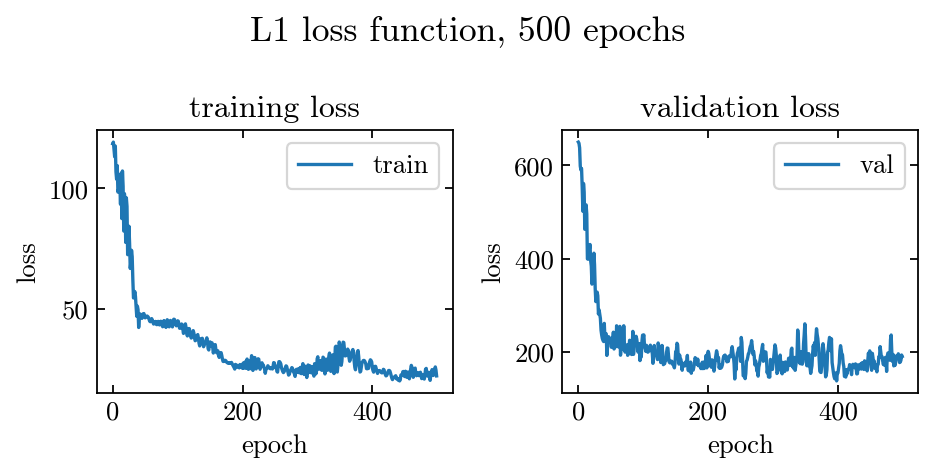

In [19]:
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'training loss')
plt.legend()
          
plt.subplot(1, 2, 2)
plt.plot(val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('validation loss')
plt.legend()
          
plt.suptitle('L1 loss function, {} epochs'.format(params['epoch']), fontsize=16)
plt.tight_layout()
plt.show()